In [1]:
import sys
sys.path.append('..')

In [2]:
from siggi import filters, spectra, calcIG
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [175]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [136]:
def prior_flat(vals):
    flat_prob = np.ones(len(vals))
    return flat_prob/np.sum(flat_prob)

In [14]:
x = np.arange(300., 1200., 25.)
y = np.arange(300., 1200., 25.)
print(len(x))
xx, yy = np.meshgrid(x, y)

36


In [26]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, [red_spec, blue_spec],
                   prior_flat, 0., 1., 1.)
        zz[x1, y1] = c.calc_IG()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [27]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,u'Information Gain Example 1')

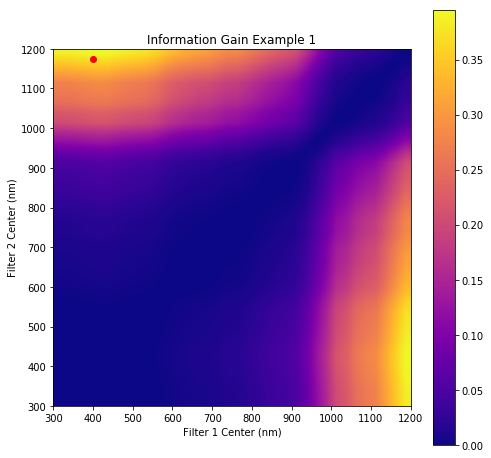

In [28]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 1')

In [29]:
x[x_max], y[y_max], zz[x_max, y_max]

(400.0, 1175.0, 0.3951608716338121)

Text(0.5,1,u'Example 1 Filters and Spectra')

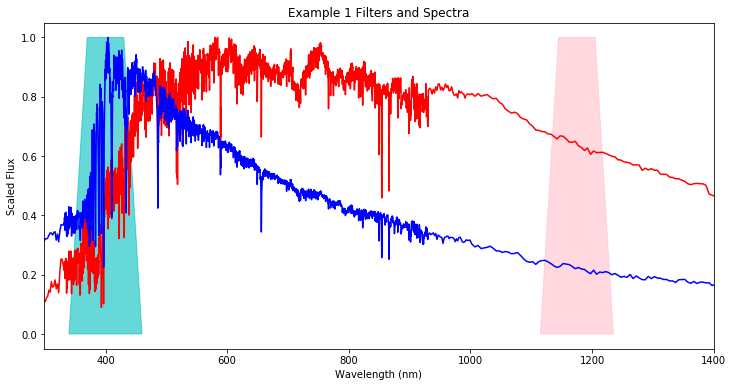

In [163]:
fig = plt.figure(figsize=(12,6))
plt.plot(red_spec.wavelen, red_spec.flambda/np.max(red_spec.flambda), c='r')
plt.plot(blue_spec.wavelen, blue_spec.flambda/np.max(blue_spec.flambda), c='b')
plt.fill([340, 370, 430, 460], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([1115, 1145, 1205, 1235], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(299., 1400.)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 1 Filters and Spectra')

### Example 2

In [46]:
s = spectra()

In [47]:
sig_spec = s.get_sigmoid_spectrum()

(200.0, 600.0)

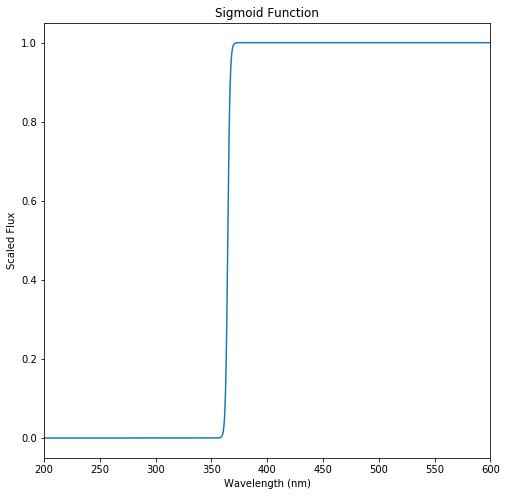

In [50]:
fig = plt.figure(figsize=(8,8))
plt.plot(sig_spec.wavelen, sig_spec.flambda)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Sigmoid Function')
plt.xlim(200., 600.)

In [51]:
y2_min = 0.
y2_max = 2.5
y2_step = 0.05

In [52]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/np.sum((z**2.)*np.exp(-(z/z0)**1.5))

Text(0.5,1,u'Redshift Prior')

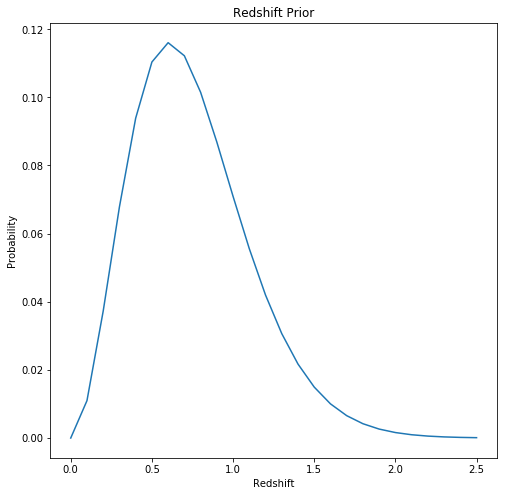

In [55]:
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(0.0, 2.56, 0.1), prior_z(np.arange(0.0, 2.56, 0.1)))
plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.title('Redshift Prior')

In [76]:
from copy import deepcopy
z_shift_seds = []
for z_val in np.arange(0., 2.51, .05):
    spec_copy = deepcopy(sig_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_seds.append(spec_copy)

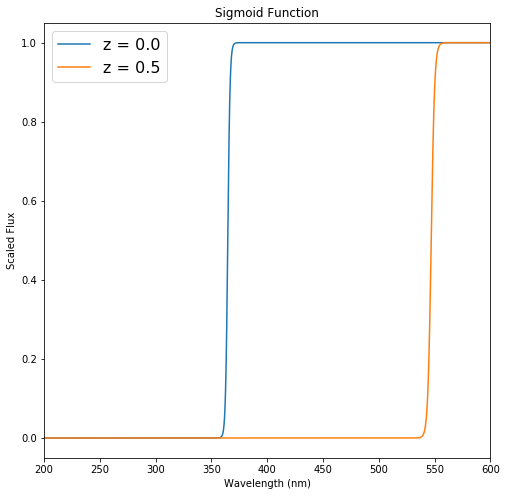

In [94]:
fig = plt.figure(figsize=(8,8))
plt.plot(sig_spec.wavelen, sig_spec.flambda, label='z = 0.0')
plt.plot(z_shift_seds[10].wavelen, z_shift_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Sigmoid Function')
plt.xlim(200., 600.)
plt.legend(fontsize=16)

In [131]:
trap_dict = f.trap_filters([[350., 80, 40], [1150., 80, 40]])
c = calcIG(trap_dict, z_shift_seds, prior_z, y2_min, y2_max, y2_step)

In [132]:
c.calc_IG()

4.410988663793439

In [104]:
x = np.arange(300., 1201., 75.)
y = np.arange(300., 1201., 75.)
print(len(x))
xx, yy = np.meshgrid(x, y)

13


In [105]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0
1
2
3
4
5
6
7
8
9
10
11
12


In [106]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,u'Information Gain Example 2')

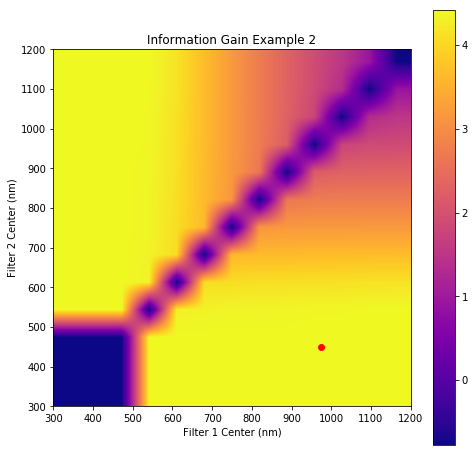

In [107]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 2')

In [108]:
x[x_max], y[y_max], zz[x_max, y_max]

(975.0, 450.0, 4.4121772114131)

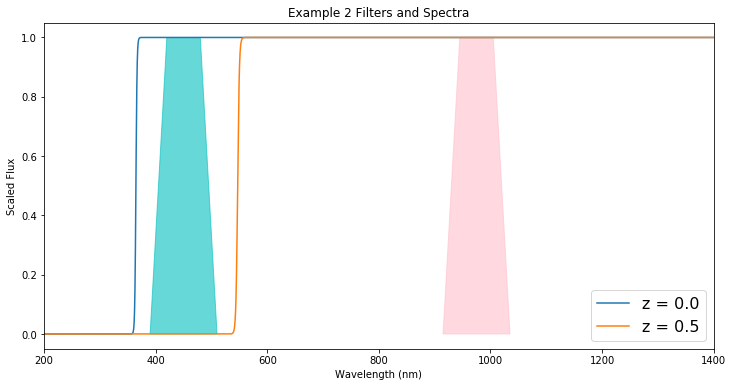

In [164]:
fig = plt.figure(figsize=(12,6))
plt.plot(sig_spec.wavelen, sig_spec.flambda, label='z = 0.0')
plt.plot(z_shift_seds[10].wavelen, z_shift_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 2 Filters and Spectra')
plt.fill([390, 420, 480, 510], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([915, 945, 1005, 1035], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)

### Example 3

In [116]:
from copy import deepcopy
z_shift_red_seds = []
for z_val in np.arange(0., 2.51, .05):
    spec_copy = deepcopy(red_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_red_seds.append(spec_copy)

In [145]:
x = np.arange(300., 1201., 75.)
y = np.arange(300., 1201., 75.)
print(len(x))
xx, yy = np.meshgrid(x, y)

13


In [146]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_red_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0
1
2
3
4
5
6
7
8
9
10
11
12


In [147]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,u'Information Gain Example 3')

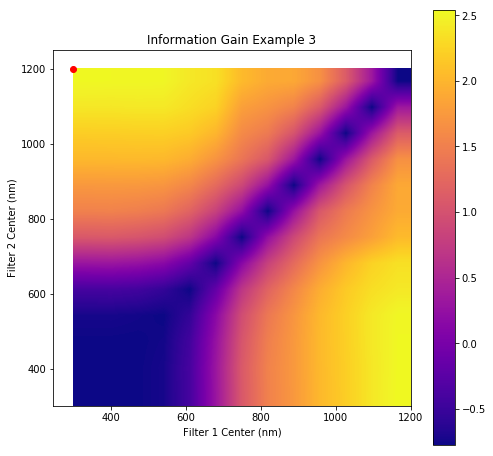

In [151]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 3')

In [149]:
x[x_max], y[y_max], zz[x_max, y_max]

(300.0, 1200.0, 2.536960112710856)

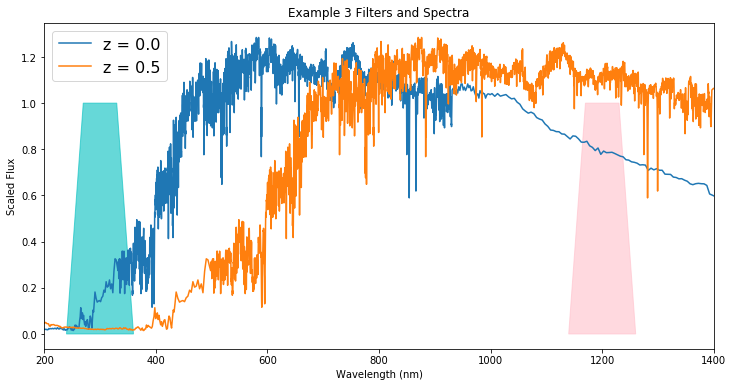

In [165]:
plt.figure(figsize=(12, 6))
plt.plot(red_spec.wavelen, red_spec.flambda, label='z = 0.0')
plt.plot(z_shift_red_seds[10].wavelen, z_shift_red_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 3 Filters and Spectra')
plt.fill([240, 270, 330, 360], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([1140, 1170, 1230, 1260], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)

### Example 3.1

In [166]:
from copy import deepcopy
z_shift_blue_seds = []
for z_val in np.arange(0., 2.51, .05):
    spec_copy = deepcopy(blue_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_blue_seds.append(spec_copy)

In [167]:
x = np.arange(300., 1201., 75.)
y = np.arange(300., 1201., 75.)
print(len(x))
xx, yy = np.meshgrid(x, y)

13


In [168]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_blue_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0
1
2
3
4
5
6
7
8
9
10
11
12


In [169]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,u'Information Gain Example 3.1')

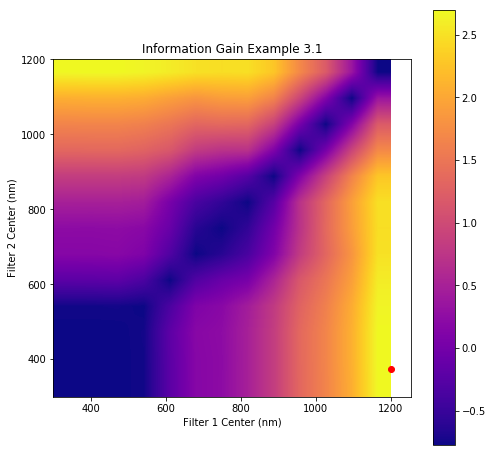

In [173]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1201., 300., 1201.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 3.1')

In [171]:
x[x_max], y[y_max], zz[x_max, y_max]

(1200.0, 375.0, 2.6932092263564265)

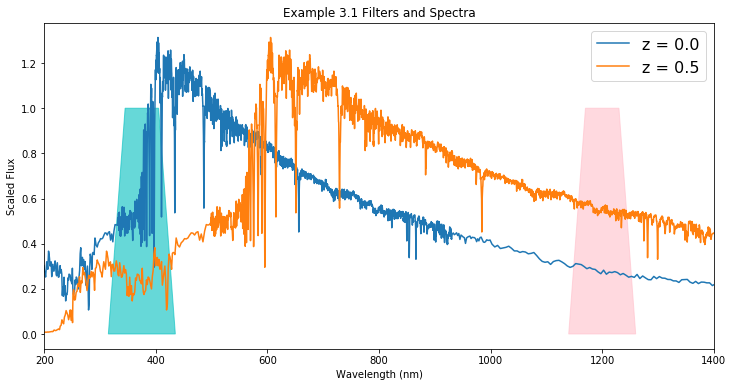

In [174]:
plt.figure(figsize=(12, 6))
plt.plot(blue_spec.wavelen, blue_spec.flambda, label='z = 0.0')
plt.plot(z_shift_blue_seds[10].wavelen, z_shift_blue_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 3.1 Filters and Spectra')
plt.fill([315, 345, 405, 435], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([1140, 1170, 1230, 1260], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)